In [1]:
import cv2
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224
RESNET_MODEL_PATH = "resnet_fruit_model.pth"  # Path to the trained ResNet model
EFFICIENTNET_MODEL_PATH = "efficientnet_fruit_model.pth"  # Path to the trained EfficientNet model

# Classes
FRUIT_CLASSES = ["1. Green", "1. Ripe", "1. Semi-Ripe", "2. Green Defect", "2. Ripe Defect", "2. Semi-Ripe Defect"]
BRUISED_CLASSES = ["Not Bruised", "Bruised"]


IMAGE_PATH = "mango.jpeg"  # Replace with your image path
IMAGE_PATH2 = "mango2-removebg-preview.png"



In [3]:
# Preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),   
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Model definition (same for both models)
class MultiTaskClassifier(nn.Module):
    def __init__(self, base_model, num_classes, bruised_classes, model_type="resnet"):
        super(MultiTaskClassifier, self).__init__()
        self.base_model = base_model
        self.model_type = model_type

        # Determine the number of input features based on the model type
        if model_type == "resnet":
            in_features = self.base_model.fc.in_features
            # Replace the fc layer with an Identity layer
            self.base_model.fc = nn.Identity()
        elif model_type == "efficientnet":
            in_features = self.base_model.classifier[1].in_features
            # Replace the classifier layer with an Identity layer
            self.base_model.classifier = nn.Identity()
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        # Define new classification layers
        self.classifier = nn.Linear(in_features, num_classes)
        self.bruised_classifier = nn.Linear(in_features, bruised_classes)

    def forward(self, x):
        x = self.base_model(x)  # Feature extraction
        fruit_class = self.classifier(x)  # Fruit and freshness classification
        bruised_class = self.bruised_classifier(x)  # Bruised/Not Bruised classification
        return fruit_class, bruised_class



In [4]:

# Load ResNet model
resnet_model = MultiTaskClassifier(models.resnet50(weights=models.ResNet50_Weights.DEFAULT), 
                                   len(FRUIT_CLASSES), len(BRUISED_CLASSES), model_type="resnet").to(DEVICE)
resnet_model.load_state_dict(torch.load(RESNET_MODEL_PATH))
resnet_model.eval()

# Load EfficientNet model
efficientnet_model = MultiTaskClassifier(models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT), 
                                         len(FRUIT_CLASSES), len(BRUISED_CLASSES), model_type="efficientnet").to(DEVICE)
efficientnet_model.load_state_dict(torch.load(EFFICIENTNET_MODEL_PATH))
efficientnet_model.eval()


C:\Users\Kenan\AppData\Local\Temp\ipykernel_28316\3586186600.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load(RESNET_MODEL_PATH))


MultiTaskClassifier(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
           

In [5]:

# Function to preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(DEVICE)
    return image

# Function to predict the class
def predict(image_path, model):
    image = preprocess_image(image_path)
    with torch.no_grad():
        fruit_pred, bruised_pred = model(image)
        fruit_class = torch.argmax(fruit_pred, dim=1).item()
        bruised_class = torch.argmax(bruised_pred, dim=1).item()
    
    fruit_name = FRUIT_CLASSES[fruit_class]
    bruise_status = BRUISED_CLASSES[bruised_class]
    
    return fruit_name, bruise_status

# Function to display the image with predictions
def display_image_with_predictions(image_path, fruit_name, bruise_status):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(f"Fruit: {fruit_name}\nBruise Status: {bruise_status}", fontsize=16)
    plt.axis('off')
    plt.show()

# Main function to run the inference
def run_inference(image_path, model):
    fruit_name, bruise_status = predict(image_path, model)
    print(f"Predicted Fruit: {fruit_name}")
    print(f"Predicted Bruise Status: {bruise_status}")
    display_image_with_predictions(image_path, fruit_name, bruise_status)

Predicted Fruit: 2. Green Defect
Predicted Bruise Status: Not Bruised


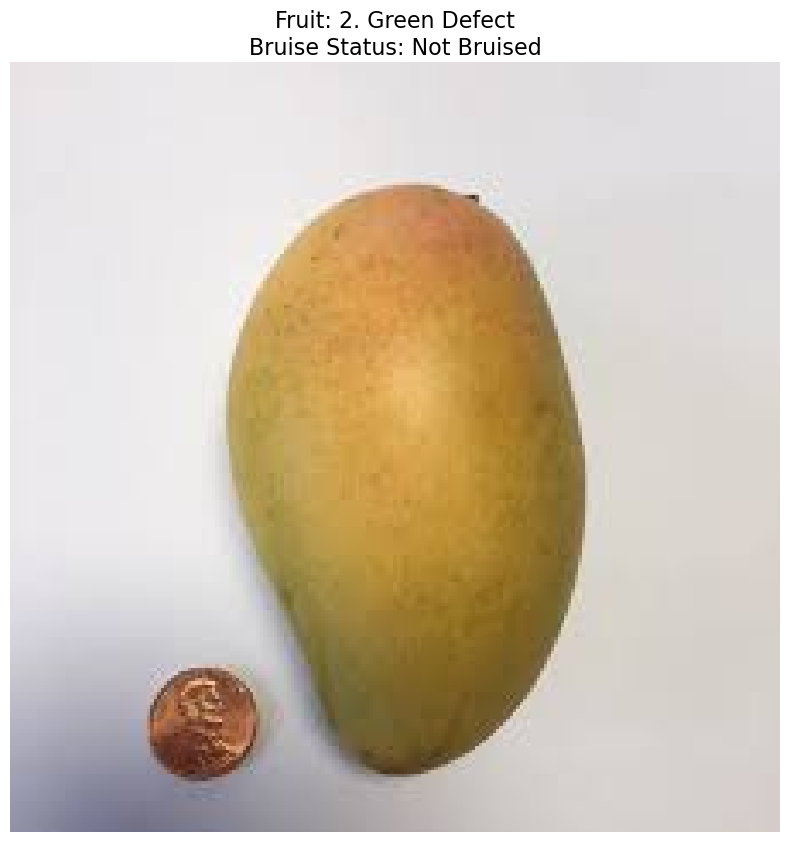

In [6]:
# Example usage
run_inference(IMAGE_PATH,efficientnet_model)

Predicted Fruit: 2. Semi-Ripe Defect
Predicted Bruise Status: Bruised


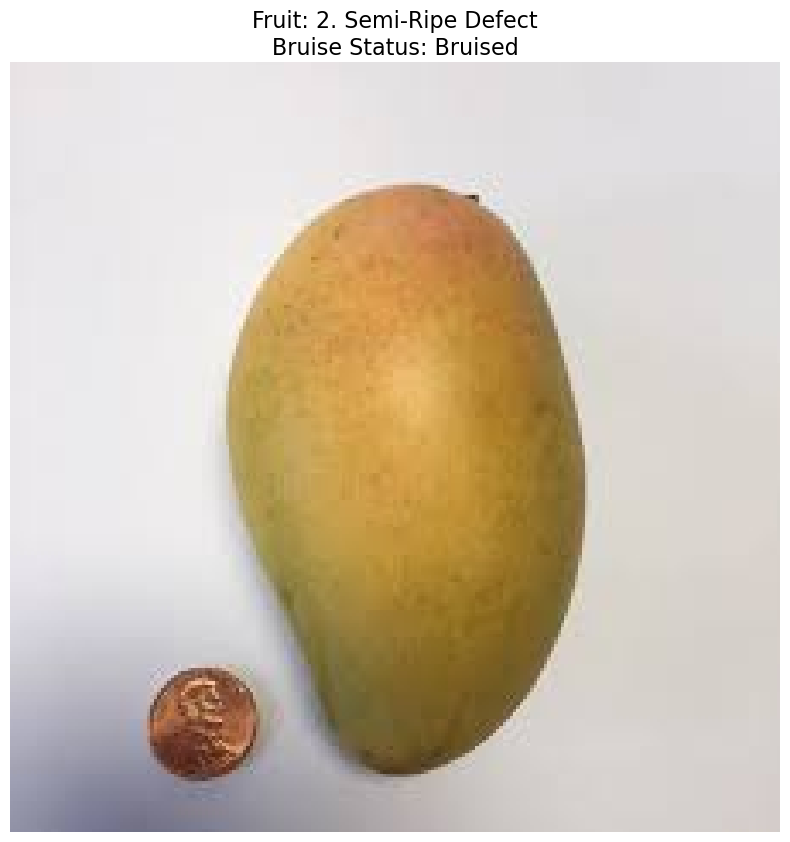

In [8]:
run_inference(IMAGE_PATH,resnet_model)

Predicted Fruit: 2. Green Defect
Predicted Bruise Status: Bruised


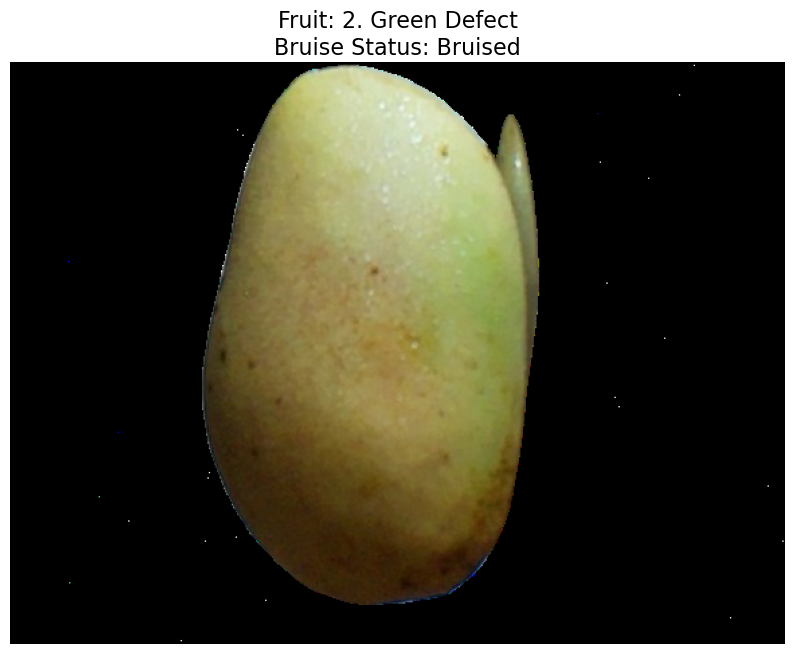

In [7]:
run_inference(IMAGE_PATH2,efficientnet_model)

Predicted Fruit: 2. Green Defect
Predicted Bruise Status: Bruised


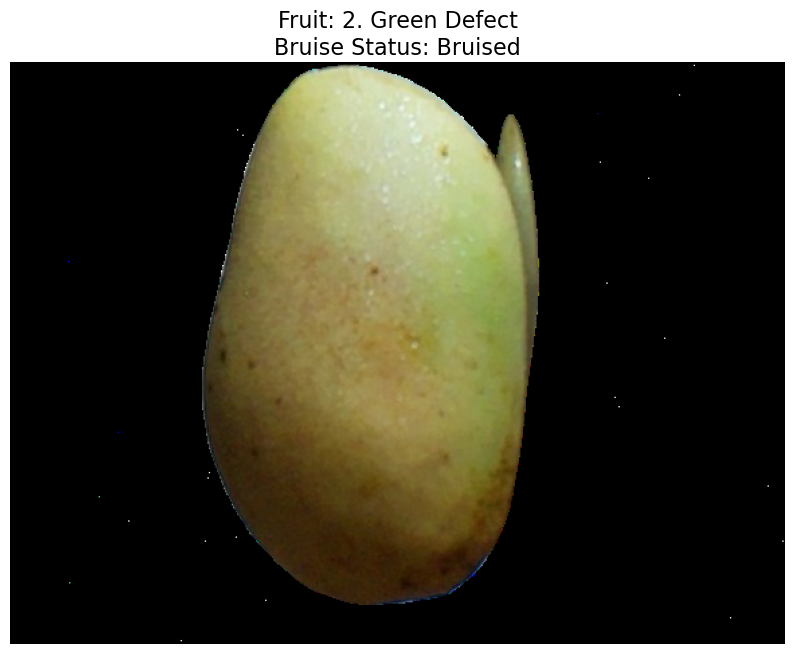

In [9]:
run_inference(IMAGE_PATH2,resnet_model)